<center><h2><strong><font color="blue">Natural Language Processing dan Text Mining (NLPTM)</font></strong></h2></center>
<center><h2><strong><font color="blue">Social Media Analytics (SMA)</font></strong></h2></center>

<center><h3><strong><font color="blue"><a href="https://taudata.blogspot.com">https://taudata.blogspot.com</a></font></strong></h3></center>

<img alt="" src="images/covers/taudata-cover.jpg"/>

<center><h2><strong><font color="blue">NLPTM-07: Pendahuluan Topic Modelling</font></strong></h2></center>
<center><h3><strong><font color="blue"><a href="https://taudata.blogspot.com/2022/05/nlptm-07.html">https://taudata.blogspot.com/2022/05/nlptm-07.html</a></font></strong></h3></center>
<b><center><h3>(C) Taufik Sutanto ~ taudata Analytics</h3></center>

## <font color="blue">Outline Topic Modelling :</font>

* Importing Data
* Pendahuluan Topic Modelling
* Soft Clustering (Topic Modelling): LDA dan NMF
* Visualisasi dan Interpretasi

In [1]:
# Jika di jalankan di komputer local, silahkan lihat NLPTM-02 untuk instalasinya.
import warnings; warnings.simplefilter('ignore')
import nltk

try:
    import google.colab
    IN_COLAB = True
    !wget https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/taudataNlpTm.py
    !mkdir data
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/slang.txt
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/stopwords_id.txt
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/stopwords_en.txt
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/kata_dasar.txt
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/wn-ind-def.tab
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/wn-msa-all.tab
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/ind_SA.csv
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/all_indo_man_tag_corpus_model.crf.tagger

    !pip install spacy python-crfsuite unidecode textblob sastrawi pyLDAvis
    !python -m spacy download xx
    !python -m spacy download en_core_web_sm
    nltk.download('popular')
except:
    IN_COLAB = False
    print("Running the code locally, please make sure all the python module versions agree with colab environment and all data/assets downloaded")

Running the code locally, please make sure all the python module versions agree with colab environment and all data/assets downloaded


In [2]:
# Importing Modules untuk Notebook ini
import taudataNlpTm as tau, itertools, re, pickle, pyLDAvis, pyLDAvis.sklearn, spacy, urllib.request
import numpy as np, matplotlib.pyplot as plt, pandas as pd, seaborn as sns 
from tqdm import tqdm
from nltk.tag import CRFTagger
from gensim.models import Phrases
from gensim.corpora.dictionary import Dictionary
from nltk.corpus import stopwords

pyLDAvis.enable_notebook()
sns.set(style="ticks", color_codes=True)
random_state = 99
'Done'

D:\Anaconda\envs\Teaching\lib\site-packages\seaborn\rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
D:\Anaconda\envs\Teaching\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
D:\Anaconda\envs\Teaching\lib\site-packages\gensim\matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu
D:\Anaconda\envs\Teaching\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
D:\Anaconda\envs\Teaching\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprec

'Done'

# Load Data

In [6]:
try:
    f = open('data/20newsgroups.pckl', 'rb')
    data = pickle.load(f)
    f.close()
except:
    categories = ['sci.med', 'talk.politics.misc',  'rec.autos']
    data = fetch_20newsgroups(categories=categories,remove=('headers', 'footers', 'quotes'))
    f = open('data/20newsgroups.pckl', 'wb')
    pickle.dump(data, f)
    f.close()
    
D = [doc for doc in data.data]
Y = data.target
print("FInished, {} documents loaded".format(len(D)))

FInished, 1653 documents loaded


# Preprocess Data

In [7]:
import taudataNlpTm as tau 
from tqdm import tqdm

stops, lemmatizer = tau.LoadStopWords(lang='en')

for i,d in tqdm(enumerate(D)):
    D[i] = tau.cleanText(d, lemma=lemmatizer, stops = stops, symbols_remove = True, min_charLen=2)
print(D[0])

1653it [26:02,  1.06it/s]

car alarm thinking ungo box knowledge experience alarms price ranges models good car alarms email responces 


# Add LDA Matrix Decomposition

In [8]:
# Kita mulai dengan membuat VSM-nya
# kita gunakan perintah yang ada di Segmen sebelumnya 
from sklearn.feature_extraction.text import CountVectorizer
tf_vectorizer = CountVectorizer()

data = D.copy()
tf = tf_vectorizer.fit_transform(data)
tf_terms = tf_vectorizer.get_feature_names()
# Mengapa tf bukan tfidf?
# Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent dirichlet allocation. Journal of machine Learning research, 3(Jan), 993-1022.
# Bisa di tamahkan dengan Frequency filtering "Max_df" dan "Min_df"

tf.shape

(1653, 20193)

In [9]:
# Dilanjutkan dengan membentuk model LDA-nya
from sklearn.decomposition import LatentDirichletAllocation as LDA

n_topics = 3 # Misal tidak di optimalkan terlebih dahulu
lda = LDA(n_components=n_topics, learning_method='batch', random_state=0).fit(tf)   
lda

LatentDirichletAllocation(n_components=3, random_state=0)

In [10]:
# Melihat Topik-topiknya
vsm_topics = lda.transform(tf)
print(vsm_topics.shape)
vsm_topics
# Ukuran kolom = #Topics ==> Dimension Reduction
# Mengapa tidak dibagi Train & Test???

(1653, 3)


array([[9.57784377e-01, 2.13871240e-02, 2.08284989e-02],
       [6.01967135e-03, 2.68781863e-01, 7.25198465e-01],
       [9.93462335e-01, 3.31201805e-03, 3.22564715e-03],
       ...,
       [3.97632296e-02, 4.11895304e-02, 9.19047240e-01],
       [3.71543190e-04, 3.91245794e-04, 9.99237211e-01],
       [1.84044707e-03, 1.92806047e-03, 9.96231492e-01]])

In [11]:
# "Seandainya" diasumsikan 1 dokumen hanya 1 topic dengan nilai skor topic terbesar
doc_topic =  [a.argmax()+1 for a in tqdm(vsm_topics)] # topic of docs
doc_topic[:10]

100%|█████████████████████████████████████████████████████████████████████████| 1653/1653 [00:00<00:00, 1209979.85it/s]


[1, 3, 1, 2, 2, 1, 3, 1, 2, 1]

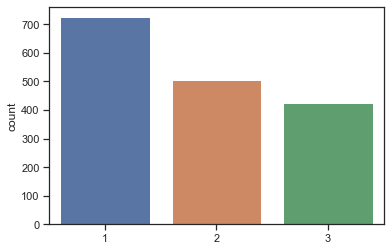

In [12]:
# mari kita plot
plot = sns.countplot(doc_topic)

In [13]:
# Mari kita coba maknai masing-masing topic ini
Top_Words = 25
print('Printing top {0} Topics, with top {1} Words:'.format(n_topics, Top_Words))
tau.print_Topics(lda, tf_terms, n_topics, Top_Words)

Printing top 3 Topics, with top 25 Words:
Topic #1:
car com edu cars good time insurance engine years problem speed better health oil drive dealer year price high driving case pain things fact power
Topic #2:
president stephanopoulos re going government time work jobs good medical question health years package american ms care day support administration year myers program cancer money
Topic #3:
msg edu time food keyboard health gordon years south banks pitt geb surrender shameful intellect skepticism chastity dsl cadre good work re secret tobacco problem


In [14]:
# %matplotlib inline
# Mari kita Plot, supaya lebih jelas
# Catatan, bergantung dari laptop yang digunakan, image terkadang cukup lama untuk muncul.
import pyLDAvis, pyLDAvis.sklearn; pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)  

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.099751 -0.067683       1        1  44.012413
0     -0.117450 -0.041092       2        1  30.762567
2      0.017699  0.108774       3        1  25.225021, topic_info=                 Term        Freq       Total Category  logprob  loglift
2536              car  453.000000  453.000000  Default  30.0000  30.0000
13872       president  380.000000  380.000000  Default  29.0000  29.0000
17153  stephanopoulos  310.000000  310.000000  Default  28.0000  28.0000
2606             cars  181.000000  181.000000  Default  27.0000  27.0000
11646             msg  118.000000  118.000000  Default  26.0000  26.0000
...               ...         ...         ...      ...      ...      ...
7567             good   55.023803  358.564283   Topic3  -6.3750  -0.4970
19956            work   52.652141  287.827741   Topic3  -6.4190  -0.3213
12229          number   49.253096  190.061257   Topic3  -6.4858   0.0270
14585              re   52.309096  379.889395   Topic3  -6.4256  -0.6054
5270           doctor   44.857889  120.140841   Topic3  -6.5792   0.3922

[229 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
55         2  0.978364             abs
307        1  0.911701  administration
307        2  0.025325  administration
307        3  0.059092  administration
672        1  0.703965        american
...      ...       ...             ...
20108      2  0.295597           years
20108      3  0.255944           years
20109      1  0.995274           yeast
20118      1  0.993029         yeltsin
20123      1  0.996002       yesterday

[362 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

# Bagaimana jika kita ingin menggunakan semi-supervised (guided) LDA?
https://medium.freecodecamp.org/how-we-changed-unsupervised-lda-to-semi-supervised-guidedlda-e36a95f3a164 

# Bagaimana melakukan Post-Tag sebelum Topic Modelling & Bahasa Indonesia?

In [15]:
# Sumber Data:
# https://github.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia/blob/master/dataset_tweet_sentiment_opini_film.csv

url_ = 'https://raw.githubusercontent.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia/master/dataset_tweet_sentiment_opini_film.csv'
file_ = 'data/dataset_tweet_sentiment_opini_film.csv'

try: # Running Locally
    data = pd.read_csv(file_)
except: # Running in Google Colab
    !mkdir data
    !wget -P data/ {url_}
    data = pd.read_csv(file_)
    data.to_csv(file_, encoding='utf-8', index=False)

col = data.columns
print("Kolom di data: ", col)
data = data[col[-1]].values
data[:5]

Kolom di data:  Index(['Id', 'Sentiment', 'Text Tweet'], dtype='object')


array(['Jelek filmnya... apalagi si ernest gak mutu bgt actingnya... film sampah',
       'Film king Arthur ini film paling jelek dari seluruh cerita King Arthur ',
       '@beexkuanlin Sepanjang film gwa berkata kasar terus pada bapaknya',
       'Ane ga suka fast and furious..menurutku kok jelek ya tu film',
       '@baekhyun36 kan gua ga tau film nya, lu bilang perang perangan/? Perang"an disebut ama rp yaoi jadi ambigu :v'],
      dtype=object)

# Preprocessing Bahasa Indonesia

In [16]:
stopID, _ = tau.LoadStopWords(lang='id')
stopID.add('rt'); stopID.add('..')

for i,d in tqdm(enumerate(data)):
    data[i] = tau.cleanText(d, lan='id', lemma=True, stops=stopID, symbols_remove = True, min_charLen = 2)
    
print(data[0])

200it [00:24,  8.30it/s]

jelek film si ernest gak mutu bgt actingnya film sampah


In [17]:
from spacy.lang.id import Indonesian
from nltk.tag import CRFTagger
nlp_id = Indonesian()  # Language Model
ct = CRFTagger()
ct.set_model_file('data/all_indo_man_tag_corpus_model.crf.tagger')

def NLPfilter(t, filters):
    tokens = nlp_id(t)
    tokens = [str(k) for k in tokens if len(k)>2]
    hasil = ct.tag_sents([tokens])
    return [k[0] for k in hasil[0] if k[1] in filters]

In [18]:
filters = set(['NN', 'NNP', 'NNS', 'NNPS', 'JJ'])
NLPfilter(data[0], filters)

['jelek', 'film', 'actingnya', 'film', 'sampah']

In [19]:
data_postTag = []
for i, d in tqdm(enumerate(data)):
    data_postTag.append(NLPfilter(d,filters))

' '.join(data_postTag[0])

200it [00:00, 5825.62it/s]


'jelek film actingnya film sampah'

In [20]:
data = [d for d in data_postTag if d]
print(data[:3])

[['jelek', 'film', 'actingnya', 'film', 'sampah'], ['film', 'king', 'arthur', 'film', 'jelek', 'cerita'], ['film', 'gwa', 'kasar']]


# Evaluasi: Bagaimana mendapatkan parameter Optimal Topic Modelling?

**Beberapa catatan penting**:
1. Hati-hati Struktur Data, untuk melakukan evaluasi Topic Modelling struktur data yang digunakan mirip dengan Word Embedding.
2. Kita akan melakukan cross-validasi dan N-Gram
3. Ada berbagai metric evaluasi https://radimrehurek.com/gensim/models/coherencemodel.html
4. Referensi paper: http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf

In [21]:
bigram_t = Phrases(data, min_count=5)
trigram_t = Phrases(bigram_t[data], min_count=5)
for idx, d in enumerate(data):
    for token in bigram_t[d]:
        if '_' in token:# Token is a bigram, add to document.
            data[idx].append(token)
    for token in trigram_t[d]:
        if '_' in token:# Token is a bigram, add to document.
            data[idx].append(token)

# Create a dictionary representation of the documents.
# Remove rare & common tokens
dictionary_t = Dictionary(data)
dictionary_t.filter_extremes(no_below=2, no_above=0.90)
#Create dictionary and corpus required for Topic Modeling
corpus_t = [dictionary_t.doc2bow(doc) for doc in data]
corpus_t = [t for t in corpus_t if t] # remove empty corpus
print('Number of unique tokens: %d' % len(dictionary_t))
print('Number of documents: %d' % len(corpus_t))
print(corpus_t[:1])

Number of unique tokens: 124
Number of documents: 182
[[(0, 2), (1, 1)]]


In [22]:
import gensim.corpora as corpora

id2word = corpora.Dictionary(data)
id2word

In [23]:
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(id2word, corpus, texts, limit=1, start=2, step=1):
    coherence_values = []
    for num_topics in range(start, limit, step):
        LDAmodel_ = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)
        cm = CoherenceModel(model=LDAmodel_, texts=texts, corpus=corpus, coherence='c_v')
        with np.errstate(invalid='ignore'):
            coherence_values.append(cm.get_coherence())
    return coherence_values

# Caution cell berikut ini membutuhkan waktu yang cukup signifikan untuk selesai, karena selain LDA *computationally expensive* loopingnya juga melakukan Cross-validasi di setiap jumlah topik *k*

In [25]:
start, step, limit = 2, 1, 10 # Ganti dengan berapa banyak Topic yang ingin di hitung/explore
coh_t, kCV = [], 5 # hati-hati sangat LAMBAT karena cross validasi pada metode yang memang tidak efisien (LDA)

print('iterasi ke: ', end = ' ')
for i in range(kCV):
    print(i+1, end = ', ', flush=True)
    c = compute_coherence_values(id2word, corpus_t, data, limit=limit, start=start, step=step)
    coh_t.append(c)
    
coherence_t = np.mean(np.array(coh_t), axis=0)
'Done'

iterasi ke:  1, 2, 3, 4, 5, 

'Done'

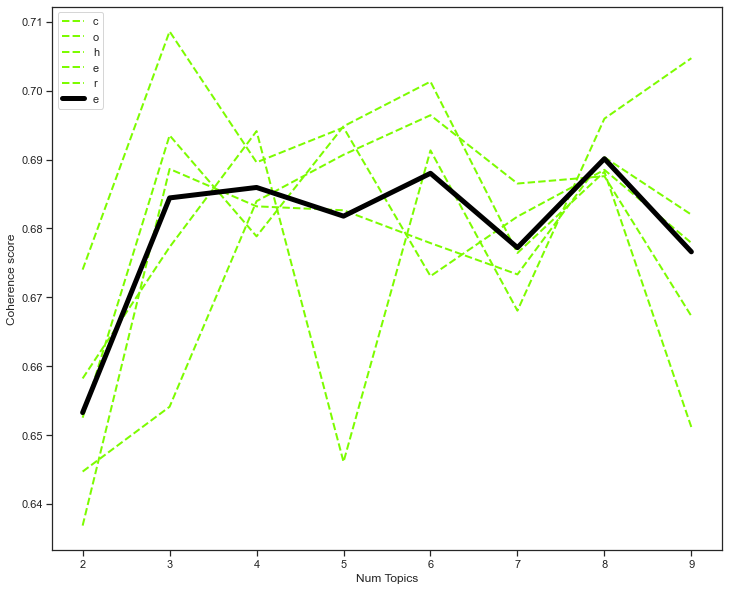

In [26]:
# Show graph
x = range(start, limit, step)
plt.figure(figsize=(12,10))
for c in coh_t:
    plt.plot(x, c, '--', color = 'lawngreen', linewidth = 2)
plt.plot(x, coherence_t, '-', color = 'black', linewidth = 5)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Referensi Pilihan:

* perhitungan Manual Topic Modelling LDA: http://brooksandrew.github.io/simpleblog/articles/latent-dirichlet-allocation-under-the-hood/
* http://mimno.infosci.cornell.edu/slides/details.pdf
* https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
* http://www.umiacs.umd.edu/~jbg/docs/nips2009-rtl.pdf
* http://radimrehurek.com/topic_modeling_tutorial/2%20-%20Topic%20Modeling.html
* Penjelasan intuitif yang baik: https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d 
* in conjunction dengan interactive program berikut: https://lettier.com/projects/lda-topic-modeling/ 

In [27]:
# Langsung Aplikasi-nya
# Perhatikan NMF bisa menggunakan Float
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

data = D.copy()

tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(data)
nmf_model = NMF(n_components = 3, random_state=0)
nmf = nmf_model.fit(tfidf)

print("\nTopics in NMF model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
tau.print_Topics(nmf, tfidf_feature_names, n_topics, Top_Words)


Topics in NMF model:
Topic #1:
geb cadre dsl pitt chastity shameful intellect skepticism banks surrender gordon edu lyme blood weight medical migraine patients good pressure meant wanted reflex dystrophy brain
Topic #2:
msg government time food re health president good years work going case doctor care jobs question things fact medical tax drugs problem disease point evidence
Topic #3:
car cars dealer engine good price buy speed drive saturn ford miles driving bought oil models tires time honda year insurance small parts power auto


In [28]:
# Sama seperti LDA kita bisa melihat distribusi topic setiap dokumen
vsm_topics = nmf.transform(tfidf)
vsm_topics[:10]

array([[0.00000000e+00, 0.00000000e+00, 1.63448478e-01],
       [5.12942523e-03, 6.71426004e-02, 3.90128123e-03],
       [0.00000000e+00, 4.14800087e-03, 8.17626429e-02],
       [5.42848147e-03, 1.14312897e-01, 0.00000000e+00],
       [0.00000000e+00, 5.45251261e-02, 9.68465028e-03],
       [0.00000000e+00, 1.21456062e-02, 4.63421722e-02],
       [8.26350147e-05, 2.27790801e-02, 6.50534348e-03],
       [0.00000000e+00, 0.00000000e+00, 5.42510101e-02],
       [0.00000000e+00, 6.31410929e-02, 6.97582495e-03],
       [1.81933383e-04, 5.15515346e-02, 1.48842001e-02]])

100%|██████████████████████████████████████████████████████████████████████████| 1653/1653 [00:00<00:00, 425348.74it/s]

In total there are 3 major topics, distributed as follows


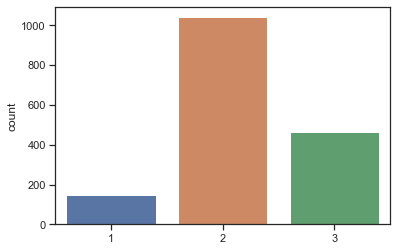

In [29]:
# Seandainya diasumsikan 1 dokumen hanya 1 topic dengan nilai skor topic terbesar
doc_topic =  [a.argmax()+1 for a in tqdm(vsm_topics)] # topic of docs
print('In total there are {0} major topics, distributed as follows'.format(len(set(doc_topic))))
sns.countplot(doc_topic)
plt.show()

# Latihan :

* Load data data tweet dengan isu berbeda.
* Lakukan preprocessing (termasuk lemma) dan pos tag (ambil hanya noun saja)
* Bandingkan hasil topic dari LDA, dan NMF dari data tersebut.
* Apakah hasilnya sudah baik?
* Buat visualisasi pyLDAvis-nya dan analisa lebih lanjut.

# End of Module

<hr />